# Problem 3 - Answers

**Particle scattering and collection in an attractive potential**

The 'mixed' scattering considered in the previous problems, involving a charged hard sphere, has not been seen by the author in describing particle scattering. However, it does appear in a different context - studying the collection and scattering of ions and electrons by a charged spherical 'dust' particle in a plasma. In this problem we will study the interaction between positively charged ions and a negatively charged dust particle in more detail. 

You may use your `collide` function from the previous problems. But the physical parameters will change somewhat. A dust particle may have a charge of -10,000e and a radius of 10$\mu m$. The incident particle might be a Hydrogen ion. The initial velocity of this particle should be added as an argument to the `collide` function, but you may use 10,000ms$^{-1}$ as a typical value to determine the simulation domain size and time step.

a) Modify your `collide` function to return True/False to indicate whether the incident ion collides with the dust grain surface, or not. 

In [1]:
%matplotlib inline
from scipy import constants
import numpy as np
import matplotlib.pyplot as plt

q1 = -constants.e * 1e4   # Dust charge
q2 = constants.e     # Hydrogen charge
m = 1.67262e-27      # Hydrogen mass
v0 = 1e4             # Initial speed

# Determine Coulomb interaction length
r_int = -q1*q2/(2*np.pi*constants.epsilon_0*m*v0**2)
print(r_int)

2.7586392035749136e-05


In [2]:
sd = 2e-4            # Size of simulation domain (in z axis)
dt = 1e-11           # Simulation time step

# Define a Coulomb potential
def Coulomb(r,Q,q):
    return Q*q/(4*np.pi*constants.epsilon_0*np.linalg.norm(r)**3) * r

# Define a function to simulate ion trajectory
# The np.vectorize decorator allows evaluation of 
#    the function over a numpy array input
@np.vectorize
def collide(b,R,v0):
    rvals = []
    r = np.array([b,0.0,-sd])
    v = np.array([0.0,0.0,v0])
    
    exited = False
    while not exited:
        rvals.append(r.copy())
        v += dt * Coulomb(r,q1,q2) / m
        r += dt * v
        if np.abs(r[2]) > sd:
            exited = True
        elif np.linalg.norm(r) <= R:
            return True
    return False

b) Define a function `bmax` which takes the radius of the dust grain and the initial speed of the ion as arguments. It should return the maximum impact parameter for which ions are 'collected' (collide with the dust surface). 

In [3]:
# finding maximum impact parameter for which collide 
# returns True, using a bisection method

def bmax(R,v0):
    dbmin = 1e-7  # desired precision on bmax
    b1 = 0.0      # minimum of interval
    b2 = sd       # maximum of interval
    
    while b2-b1 > dbmin:
        if collide(0.5*(b1+b2),R,v0):
            b1 = 0.5*(b1+b2)
        else:
            b2 = 0.5*(b1+b2)
    return 0.5*(b1+b2)
    

c) Pick a range of values for initial ion speeds (e.g. speeds between 10$^3$ms$^{-1}$ and 10$^5$ms$^{-1}$). Evaluate the value of bmax for each of these speeds, and make a plot. How does this compare against the function:

$$ b = R\sqrt{1-\frac{2Qq}{4\pi\epsilon_0Rmv^2}}  $$

This expression, which can be derived straightforwardly from conservation of energy and momentum, is key to the 
<a href=https://doi.org/10.1017/S0022377800008345">Orbital Motion Limited (OML)</a> model of dust charging in a plasma, and while never being stricted valid is a useful model.

In [4]:
vs = np.logspace(3,5,20)
bmaxs = []
for v in vs:
    bmaxs.append(bmax(1e-5,v))
    print(bmaxs[-1])

0.00016313476562500003
0.000127978515625
0.000100439453125
7.905273437500002e-05
6.2255859375e-05
4.9267578125e-05
3.911132812500001e-05
3.1298828125e-05
2.5341796875e-05
2.0849609375e-05
1.7529296875e-05
1.5087890625e-05
1.3330078125e-05
1.2158203125000001e-05
1.1376953125e-05
1.0888671875000002e-05
1.0498046875000001e-05
1.0302734375000002e-05
1.0205078125000001e-05
1.0107421875000002e-05


We see that faster ions are collected across a smaller cross section, as they have less time to be deflected in the Coulomb potential. So bmax tends towards the dust radius for large v. Making a plot against the OML model:

Text(0, 0.5, '$b_{max} (\\mu m)$')

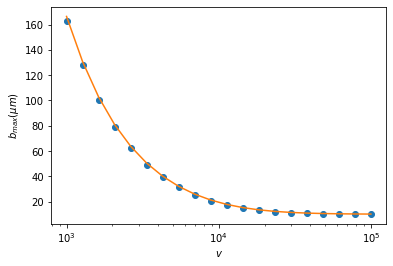

In [5]:
plt.plot(vs,1e6*np.array(bmaxs),'o')
plt.plot(vs,10*np.sqrt(1-2*q1*q2/(4*np.pi*constants.epsilon_0*1e-5*m*vs**2)))
plt.xscale('log')
plt.xlabel(r'$v$')
plt.ylabel(r'$b_{max} (\mu m)$')

d) In reality, the potential around a charged body in a plasma does not look like a Coulomb potential, but instead takes the form of the <a href=https://en.wikipedia.org/wiki/Debye_length">
Debye–Hückel potential</a>, which is an exponentially decaying Coulomb potential with a decay length $\lambda_D$:

$$ F_{D} = \frac{Qq}{4\pi\epsilon_0r^3} \exp{\left(\frac{-r}{\lambda_D}\right)} \mathbf{r} $$
    
Define a function that specifies the Debye–Hückel potential, and use it to solve for and plot the $b_{max}$ vs $v$ profiles for values of $\lambda_D$ that are smaller than, larger than, and equal to the radius of the dust particle. How do these profiles compare to the OML model?

In [6]:
# Define a Debye-Huckel potential
def Debye(r,Q,q,L):
    return Q*q/(4*np.pi*constants.epsilon_0*np.linalg.norm(r)**3) * np.exp(-np.linalg.norm(r)/L) * r

# Redefine the collide and bmax functions to use the Debye-Huckel
# potential with a variable decay length L
@np.vectorize
def collide(b,R,v0,L):
    rvals = []
    r = np.array([b,0.0,-sd])
    v = np.array([0.0,0.0,v0])
    
    exited = False
    while not exited:
        rvals.append(r.copy())
        v += dt * Debye(r,q1,q2,L) / m
        r += dt * v
        if np.abs(r[2]) > sd:
            exited = True
        elif np.linalg.norm(r) <= R:
            return True
    return False

def bmax(R,v0,L):
    dbmin = 1e-7  # desired precision on bmax
    b1 = 0.0      # minimum of interval
    b2 = sd       # maximum of interval
    
    while b2-b1 > dbmin:
        if collide(0.5*(b1+b2),R,v0,L):
            b1 = 0.5*(b1+b2)
        else:
            b2 = 0.5*(b1+b2)
    return 0.5*(b1+b2)

In [7]:
vs = np.logspace(3,5,20)
bmaxs1 = []
bmaxs2 = []
bmaxs3 = []
for v in vs:
    bmaxs1.append(bmax(1e-5,v,3e-6))  # lambda_D < dust radius
    bmaxs2.append(bmax(1e-5,v,1e-5))  # lambda_D = dust radius
    bmaxs3.append(bmax(1e-5,v,3e-5))  # lambda_D > dust radius

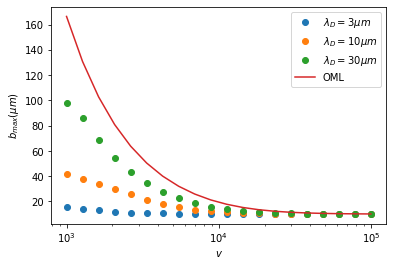

In [8]:
plt.plot(vs,1e6*np.array(bmaxs1),'o',label=r'$\lambda_D=3\mu m$')
plt.plot(vs,1e6*np.array(bmaxs2),'o',label=r'$\lambda_D=10\mu m$')
plt.plot(vs,1e6*np.array(bmaxs3),'o',label=r'$\lambda_D=30\mu m$')
plt.plot(vs,10*np.sqrt(1-2*q1*q2/(4*np.pi*constants.epsilon_0*1e-5*m*vs**2)),label='OML')
plt.xscale('log')
plt.xlabel(r'$v$')
plt.ylabel(r'$b_{max} (\mu m)$')
plt.legend()

It is only in the limit where the dust radius is much smaller than $\lambda_D$ that OML describes ion collection - for larger dust, ions are only collected within a few $\lambda_D$ of the dust surface.